In [2]:
#import necessary modules:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from tqdm import tqdm
import random
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

In [3]:
class TestDataSet(Dataset):
    #initialize transforms, the df, and directory for image and id
    def __init__(self, df, transforms = None):
        self.df = df
        self.imagepaths = df["imagepath"].tolist()
        self.transforms = transforms

    def __len__(self): # upperbound of idx (index), so how many images we have
        return len(self.df) # length of df is how many images we have

    def __getitem__(self,idx): # index = each row of df
        # read image:
        image_path = self.imagepaths[idx]
        img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transforms is not None:
            image = self.transforms(img)
        return torch.tensor(image)

In [4]:
# all model configs go here so that they can be changed when we want to:
# Make sure this model_config is same as the train model_config when running inference:
class model_config:
    seed = 42
    model_name = "efficientnetv2_l"
    train_batch_size = 16
    valid_batch_size = 39 # Test_df has 780 images, so 20 batches
    epochs = 5
    learning_rate = 0.001
    scheduler = "CosineAnnealingLR"
    T_max = int(30000/train_batch_size*epochs) # for cosineannealingLR, explore different values
    weight_decay = 1e-6 # explore different weight decay (Adam optimizer)
    n_accumulate = 1
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    iters_to_accumulate = max(1,32//train_batch_size) # for scaling accumulated gradients
    eta_min = 1e-5
    model_save_directory = r"\\fatherserverdw\Kevin\unstained_blank_classifier\models" #os.path.join(os.getcwd(),"model") #assuming os.getcwd is the wsi_analysis directory

In [5]:
# sets the seed of the entire notebook so results are the same every time we run for reproducibility. no randomness, everything is controlled.
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # when running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(model_config.seed)

In [6]:
def return_f1_score(y_true,y_pred):
    f_one_score = f1_score(y_true,y_pred)
    return f_one_score

In [8]:
def build_model():
    model = timm.create_model(model_config.model_name,pretrained=False)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features,1) #in_features = 1280, out_features = 1, so that 0 or 1 binary classification
    # model.add_module('sigmoid', nn.Sigmoid()) # obtain probability b/w 0 and 1
    model.to(model_config.device) # model to gpu
    return model

In [9]:
val_transform = transforms.Compose([
 # validate at 1024 x 1024, you want to use val dataset to real world application, but maybe resize to 384 if performance is bad.
    #transforms.Resize(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2966, 0.3003, 0.3049], std=[0.4215, 0.4267, 0.4332]) #calculated above mean & std
])

In [10]:
@torch.no_grad()
def infer(model_paths, test_loader, thr=0.5):
    pred_classes = []
    model = build_model()  #initialize the model outside the loop

    for idx, image in enumerate(tqdm(test_loader, total=len(test_loader), desc='Inference')):
        image = image.to(model_config.device, dtype=torch.float)
        label = torch.zeros((model_config.valid_batch_size, 1), device=model_config.device) #BS x 1 empty tensor reinitialized for each batch

        for path in model_paths:
            model.load_state_dict(torch.load(path))
            model.eval()
            output = model(image)
            output = nn.Sigmoid()(output) #0~1 probabilities
            label += output #ensemble, add first

        label /= len(model_paths)  #ensemble, average the probabilities
        labels = (label > thr).to(torch.uint8).cpu().detach().numpy() # if > 0.5, 1 else <0.5, 0.
        pred_classes.extend(labels)

    pred_df = pd.DataFrame({"predicted": pred_classes})
    return pred_df


In [11]:
_# open test_df:
test_df_src = r"\\fatherserverdw\Kevin\unstained_blank_classifier\test_df.xlsx"
test_df = pd.read_excel(test_df_src)
test_df

,Unnamed: 0,imagepath,label
0,0,\\shelter\Kyu\unstain2stain\tiles\registered_t...,1
1,1,\\shelter\Kyu\unstain2stain\tiles\registered_t...,1
2,2,\\shelter\Kyu\unstain2stain\tiles\registered_t...,1
3,3,\\shelter\Kyu\unstain2stain\tiles\registered_t...,1
4,4,\\shelter\Kyu\unstain2stain\tiles\registered_t...,1
...,...,...,...
775,359,\\shelter\Kyu\unstain2stain\tiles\registered_t...,0
776,360,\\shelter\Kyu\unstain2stain\tiles\registered_t...,0
777,361,\\shelter\Kyu\unstain2stain\tiles\registered_t...,0
778,362,\\shelter\Kyu\unstain2stain\tiles\registered_t...,0


In [12]:
test_dataset = TestDataSet(test_df, transforms = val_transform)
test_loader  = DataLoader(test_dataset, batch_size=model_config.valid_batch_size,
                          num_workers=0)
saved_model_path = model_config.model_save_directory
model_paths  = glob(f'{saved_model_path}/best_epoch*.pt')
print("Model list are {}".format(model_paths))
pred_df = infer(model_paths, test_loader)
pred_df

Model list are ['\\\\fatherserverdw\\Kevin\\unstained_blank_classifier\\models\\best_epoch-03.pt', '\\\\fatherserverdw\\Kevin\\unstained_blank_classifier\\models\\best_epoch-04.pt']


Inference:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\Kevin\AppData\Local\Temp\ipykernel_7572\2804195440.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)
Inference: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]


,predicted
0,[1]
1,[1]
2,[1]
3,[1]
4,[1]
...,...
775,[0]
776,[0]
777,[0]
778,[0]


In [13]:
y_pred = pred_df["predicted"].tolist()
y_pred = [int(x) for x in y_pred]
y_true = test_df["label"].tolist()

In [14]:
def calculate_f1_score(y_true, y_pred):
    #confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #extract values from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    #return precision, recall, and F1 score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1, precision, recall, cm

In [15]:
def plot_confusion_matrix(confusion_matrix):
    labels = ['Negative', 'Positive']
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

F1 Score: 0.9033659066232357
Precision: 0.8237623762376237
Recall: 1.0


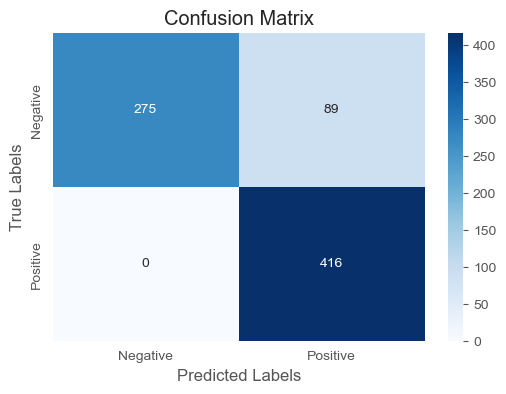

In [16]:
f1_score, precision, recall, cm = calculate_f1_score(y_true, y_pred)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)
plot_confusion_matrix(cm)

### Remember 1 = White and 0 = Non-White. In Test_df, we have 416 1's, or whites, and the rest 364 0's or non-whites. Above, we can see that the model does perfectly in classifying the white images but does quite poorly on non-white images, as it predicted 89 tiles as white when it really is not. Let's open some images that the model screwed up on!

In [20]:
def find_mismatch_indexes(list1, list2):
    mismatch_indexes = []
    for i, (val1, val2) in enumerate(zip(list1, list2)):
        if val1 != val2:
            mismatch_indexes.append(i)
    return mismatch_indexes

def sample_file_paths(file_paths, indexes):
    sampled_indexes = random.sample(indexes, 5)  # Randomly sample 5 indices
    sampled_file_paths = [file_paths[i] for i in sampled_indexes]  # Retrieve file paths using sampled indices
    return sampled_file_paths

In [21]:
wrong_image_indexes = find_mismatch_indexes(y_true, y_pred)
image_list = test_df["imagepath"].tolist()
some_wrong_image_paths = sample_file_paths(image_list,wrong_image_indexes)
some_wrong_image_paths

['\\\\shelter\\Kyu\\unstain2stain\\tiles\\registered_tiles\\US\\OTS_14832_3\\65666_39759xy1743.png',
 '\\\\shelter\\Kyu\\unstain2stain\\tiles\\registered_tiles\\US\\OTS_14684_4\\31336_40783xy0655.png',
 '\\\\shelter\\Kyu\\unstain2stain\\tiles\\registered_tiles\\US\\OTS_14684_4\\29288_39759xy0498.png',
 '\\\\shelter\\Kyu\\unstain2stain\\tiles\\registered_tiles\\US\\OTS_14684_4\\34408_55119xy0903.png',
 '\\\\shelter\\Kyu\\unstain2stain\\tiles\\registered_tiles\\US\\OTS_14684_4\\34408_44879xy0893.png']

In [22]:
for src in some_wrong_image_paths:
    image = Image.open(src)
    image.show()